### Visualizing the Mean Absolute Error between forecast runs

In [1]:
import logging

import matplotlib.pyplot as plt

from jua import JuaClient
from jua.weather import Models, Variables

logging.basicConfig(level=logging.INFO)

In [2]:
# Setup the client and the model to use
client = JuaClient()
model = client.weather.get_model(Models.EPT1_5)

In [3]:
# Define the data we want to load
europe_lat_slice = slice(36, 71)
europe_lon_slice = slice(-15, 50)
forecast_window = slice(0, 48)  # Hours
variables = [
    Variables.AIR_TEMPERATURE_AT_HEIGHT_LEVEL_2M,
    Variables.WIND_SPEED_AT_HEIGHT_LEVEL_100M,
]

In [4]:
# Load the latest and second-to-last forecast
# This will take some time to load, depending on the speed of the internet connection
# Usually roughly 2 minutes total
# Skipping to latest forecast to ensure we always have a full forecast available
forecast_a_init_time = model.forecast.get_available_init_times()[1]
print(f"Loading forecast for init_time={forecast_a_init_time}")
forecast_a = model.forecast.get_forecast(
    init_time=forecast_a_init_time,
    variables=variables,
    latitude=europe_lat_slice,
    longitude=europe_lon_slice,
    prediction_timedelta=forecast_window,
)
forecast_b_init_time = model.forecast.get_available_init_times()[2]
print(f"Loading forecast for init_time={forecast_b_init_time}")
forecast_b = model.forecast.get_forecast(
    init_time=forecast_b_init_time,
    variables=variables,
    latitude=europe_lat_slice,
    longitude=europe_lon_slice,
    prediction_timedelta=forecast_window,
)

2025-05-15 14:34:24,067 - jua.weather.forecast - WARNING - Large query, this might take some time. (forecast.py:321)


Loading forecast for init_time=2025-05-15 00:00:00+00:00


2025-05-15 14:35:00,294 - jua._utils.dataset - INFO - Opening dataset... (dataset.py:164)
2025-05-15 14:35:00,295 - jua._utils.dataset - INFO - Loading dataset of size 0.12GB (dataset.py:174)


[########################################] | 100% Completed | 29.27 s


2025-05-15 14:35:29,946 - jua.weather.forecast - WARNING - Large query, this might take some time. (forecast.py:321)


Loading forecast for init_time=2025-05-14 18:00:00+00:00


2025-05-15 14:36:06,285 - jua._utils.dataset - INFO - Opening dataset... (dataset.py:164)
2025-05-15 14:36:06,286 - jua._utils.dataset - INFO - Loading dataset of size 0.12GB (dataset.py:174)


[########################################] | 100% Completed | 27.44 s


<xarray.Dataset> Size: 116MB
Dimensions:                             (latitude: 432, longitude: 802,
                                         absolute_time: 42, time: 1)
Coordinates:
  * latitude                            (latitude) float32 2kB 70.95 ... 36.02
  * longitude                           (longitude) float32 3kB -15.0 ... 49.95
  * absolute_time                       (absolute_time) datetime64[ns] 336B 2...
Dimensions without coordinates: time
Data variables:
    air_temperature_at_height_level_2m  (time, absolute_time, latitude, longitude) float32 58MB ...
    wind_speed_at_height_level_100m     (time, absolute_time, latitude, longitude) float32 58MB ...


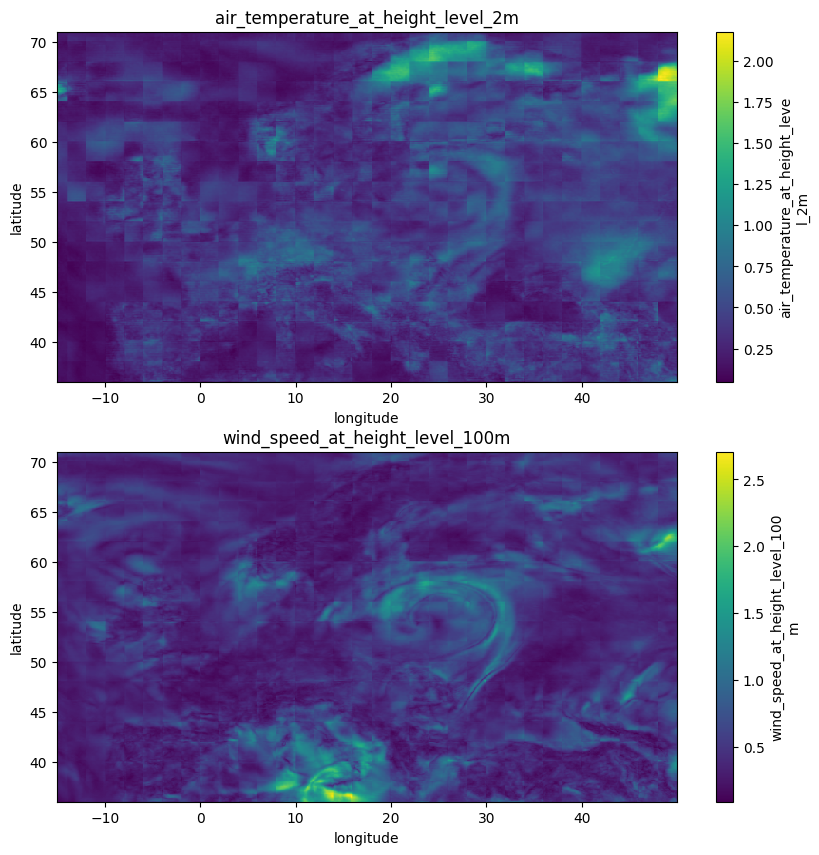

In [5]:
# Instead of prediction_timedelta, we use absolute_time
# so we can compare the two forecasts
# Adds a new dimension to the dataset
forecast_a_ds = forecast_a.to_xarray().to_absolute_time()
forecast_b_ds = forecast_b.to_xarray().to_absolute_time()

# Next we drop the time dimension
forecast_a_ds = forecast_a_ds.drop_vars("time")
forecast_b_ds = forecast_b_ds.drop_vars("time")

# Stack the two datasets base
delta = forecast_a_ds - forecast_b_ds
delta_abs = abs(delta)
delta_mean = delta_abs.mean(dim="absolute_time")
print(delta_abs)
num_vars = len(variables)
_, axs = plt.subplots(num_vars, 1, figsize=(10, num_vars * 5))
for i, var in enumerate(variables):
    delta_mean[var].plot(ax=axs[i])
    axs[i].set_title(var)
plt.show()